<hr style="width:100%;height:1px">
<table style="width:100%">
  <tr style="background-color:rgb(255,255,255)">
    <th style="width:25%">
    <img src="iut.png" alt="دانشگاه صنعتی اصفهان" style="width:120px;height:120px;">
    </th>
    <th style="width:75%">
    <p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:12pt">
    .::به نام خداوند بخشنده و بخشایشگر مهربان::.
    </p>
    <p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:12pt">
    پروژه نهایی درس شبکه عصبی - دانشگاه صنعتی اصفهان - نیم سال اول تحصیلی سال ۹۷-۱۳۹۸
    </p>
    <p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:12pt">
    پروژه ۱: رنگ آمیزی تصویر خاکستری
    </p>
    </th>
  </tr>
</table>

<hr style="width:100%;height:1px">

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
نام و نام خانوادگی :
</p>


<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
شماره دانشجویی:
</p>

<hr style="width:100%;height:1px">

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
در این تمرین می‌خواهیم یک شبکه عصبی کانولوشنی را به گونه‌ای آموزش دهیم که در نهایت بتواند  تصاویر خاکستری ورودی را رنگ آمیزی کند! ابتدا اجازه دهید که بسته‌هایی در این پروژه نیاز دارید را به برنامه اضافه کنیم. شما می‌توانید در سلول پایین کتابخانه‌های دیگری را که فکر می‌کنید به آن‌ها نیاز دارید را اضافه کنید.
</p>

In [1]:
import keras
from keras.layers import Conv2D, Deconv2D, MaxPool2D, UpSampling2D, BatchNormalization
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.optimizers import adam
from matplotlib import pyplot as plt, cm
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
horse_idx = np.where(y_train==7)[0]
y_train = x_train[horse_idx] / 255.0
x_train = x_train[horse_idx] / 255.0
horse_idx = np.where(y_test==7)[0]
y_test = x_test[horse_idx] / 255.0
x_test = x_test[horse_idx] / 255.0

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
چنانچه بخواهید مسأله را در حالت رگرسیون حل کنید، از داده‌های  
y_train و y_test 
که در سلول بالا تولید شده‌اند می‌توانید استفاده کنید. ۹ برچسب داده‌های آموزشی در سلول پایین نشان داده شده است.
</p>

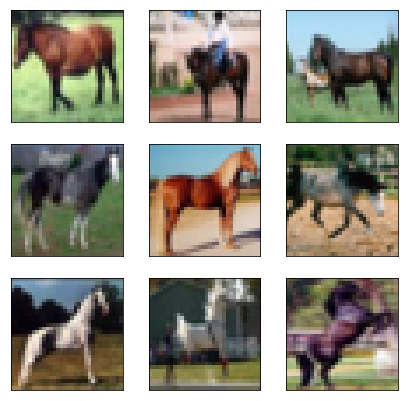

In [4]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(y_train[i])
    plt.xticks([])
    plt.yticks([])

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
اما اگر بخواهید مسأله را در حالت دسته‌بندی حل کنید، ابتدا تصاویر برچسب سطح بندی می‌شوند، این کار با استفاده از الگوریتم خوشه بندی 
kmeans 
به ۱۶ سطح تقسیم شده است. می‌توانید در اینترنت یا مقالات مختلف جستجو نمایید که بدانید به چه صورت از این داده‌ها استفاده می‌شود.
</p>

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
تابع 
quantize16 
رنگ تصاویر که در ۲۵۶ سطح هست را به ۱۶ سطح کاهش می‌دهد. 
<b>
آیا می‌توانید توضیح دهید که دو خروجی این تابع 
J و L 
هر کدام شامل چه محتوایی هستند؟
</b>
</p>

In [5]:
colors = np.load('colour_kmeans16_cat7.npy', allow_pickle=True, encoding='latin1')[0]
def quantize16(I):
    J = np.zeros((32, 32, 3))
    L = np.zeros((32, 32, 16))
    K = np.zeros((32, 32, 16))
    for i in range(16):
        d = 0
        for j in range(3):
            d = (I[:,:,j] - colors[i, j])**2 + d
        d = d**0.5
        K[:, :, i] = d
    k = K.argmin(-1)
    for i in range(16):
        m,n = np.where(k == i)
        for j in range(3):
            J[m, n, j] = colors[i, j]
        J = J.astype(I.dtype)
        L[m, n, i] = 1.0
    return J, L

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
در سلول زیر ۹ تصویر برچسب که کوانتیزه شده‌اند به عنوان نمونه نشان داده شده اند.
</p>

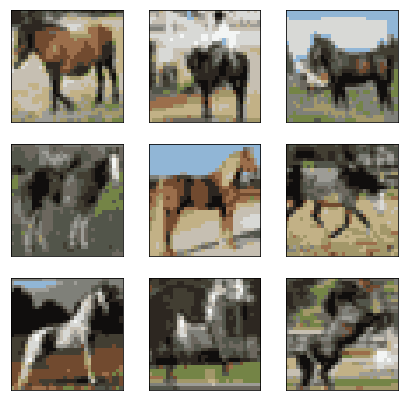

In [6]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    I, _ = quantize16(y_train[i].copy())
    plt.imshow(I)
    plt.xticks([])
    plt.yticks([])

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
حال اگر می‌خواهید در حالت دسته بندی مسأله را حل نمایید، در سلول زیر برچسب‌های آموزشی را مشابه آنچه در کد بالا انجام شده است تولید نمایید. این کار را باتوجه پاسخی که به سوال قبل دادید انجام دهید.
</p>

In [7]:
# you must process on y_train and y_test as the above example, if you want to solve as classification, in quantize16
# be aware of differences between J and L:
# --- write your code here ----- # (if you want solve in classifiaction mode.)



<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
در سلول زیر ۹ تصویر برچسب که کوانتیزه شده‌اند به عنوان نمونه نشان داده شده اند.
</p>

In [8]:
def rgb2grey(I):
    J = I[:, :, 0] * 0.299 + I[:, :, 1] * 0.587 + I[:, :, 2] * 0.114
    return J

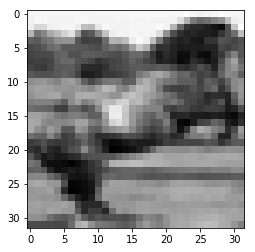

In [9]:
J = rgb2grey(x_train[11])
plt.imshow(J, cm.gray)

In [10]:
# in this cell, write code and make your dataset grey, see example at top, and make x_train and x_test:
## ---- write your code here ---- #



<hr style="width:100%;height:1px">

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
خب تا الان شما پایگاه داده مورد نیاز خودتان را ایجاد کرده‌اید. حالا در سلول پایین یک مدل از 
keras 
ایجاد کنید.
</p>

In [11]:
# define yout CNN model:
## ---- write your code here ----- #




<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
مدل شبکه خود را با یک تابع هزینه و روش بهینه سازی مناسب کامپایل کنید:
</p>

In [12]:
# model.compile(loss="proper_loss", optimizer="proper_optimizer like sgd, adam, ..")
## write your code here: ---- #


<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
سعی کنید از مدل خود یک شمای گرافیکی یا جدولی ارایه دهید:
</p>

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
حال مدل خود را با تعداد ایپاک‌های کافی و سایر پارامترهای مناسب آموزش دهید:
</p>

In [13]:
# model.fit 
# ---- write your coded here: ---- #




<hr style="width:100%;height:1px">

<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
حال خروجی شبکه را به ازای ۱۰ تصویر آزمون و ۱۰ تصویر آموزش محاسبه کنید و نمایش دهید:
</p>

In [14]:
# predict model on test data and plot, is it works?:
# ---- write your code here: ----- #




In [15]:
# predict model on train data and plot, is it works?:
# ---- write your code here: ----- #




<p style="direction:rtl;text-align:right;font-family:'B Mitra';font-size:14pt">
<b>
آیا با توجه به دو مجموعه بالا مدل شما به درستی آموزش داده شده است؟ کمی توضیح دهید.
</b>
</p>

<hr style="width:100%;height:1px">

<p style="direction:rtl;text-align:left;font-family:'B Mitra';font-size:14pt">
<b>
موفق و پیروز باشید.
</b>
</p>